# Loading Libraries

In [78]:
import itertools, string, re, nltk
#nltk.download()
import os
import json
from datetime import datetime, timezone
import pandas as pd
import numpy as np
from goose3 import Goose
#from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk import bigrams
from itertools import combinations
from collections import Counter
from gensim.models.phrases import Phrases
from textblob_de import TextBlobDE as TextBlob
from sklearn.feature_extraction.text import CountVectorizer

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("darkgrid")
from wordcloud import WordCloud

# Helper Functions

In [79]:
# Tweet processor
def process_tweet(tweet):
    record = dict()
    record['id'] = tweet['id']
    record['created_at'] = tweet['created_at']

    if tweet['truncated'] == False:
        record['text'] = tweet['text']
    else:
        record['text'] = tweet['extended_tweet']['full_text']

    return record

# Tokenizer
def tokenizer(text): #Splits words on white spaces and splits out trailing punctuation
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

# Lemmatizer  
def lemmatizer(tagged_text):
    lemma_word = []
    for word in tagged_text:
        lemma_word.append(WordNetLemmatizer().lemmatize(word))
    return lemma_word


# Punctuation
punc = list(set(string.punctuation))

# Stop Words
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('german') + [
    'ja',
    'sei',
    'seien',
    'seit',
    'sagt',
    'sagte',
    'schon',
    'geht',
    'gibt',
    'etwa',
    'müssen',
    'denen',
    'dabei',
    'sollen',
    'beim',
    'ab',
    'wäre',
    'hätte',
    'müsste',
    'hätte',
    'hätten',
    'heisst',
    'wurde',
    'darauf',
    'worden',
    'gar',
    'zudem',
    'tun',
    'lassen',
    'deshalb',
    'wurden',
    'sollen',
    'deshalb',
    'immer',
    'mehr',
    'via',
    '„',
    '“',
    '–',
    '``',
    '``',
    "''",
    '„',
    '«',
    '»',
    '”',
    '%',
    '|',
    '&',
    '.',
    ',',
    '--',
    '\'s',
    '?',
    ')',
    '(',
    ':',
    '\'',
    '\'re',
    '"',
    '""',
    '-',
    '}',
    '{',
    u'—',
    ']',
    '[',
    '...',
    '•',
    ':',
    '.',
    'n•'
    ]

# Text processing
def process_text(text):
    no_html = re.sub(r'https?://[a-z0-9./]+', '', text).strip()
    tokenized = tokenizer(no_html)
    lower = [item.lower() for item in tokenized]
    no_punc = [w for w in lower if w not in punc]
    no_stop = [w for w in no_punc if w not in stop_words]
    lemma = lemmatizer(no_stop)
    return lemma

# EDA
def sent_count(text):
    sentences = nltk.tokenize.sent_tokenize(text)
    return len(sentences)

def word_count(text):
    return len(str(text).split(' '))

# Word Frequency & bigrams

#Most frequently occuring words    
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

#Most frequently occuring Bigrams _range=(2,2) / Trigrams _range=(3,3)
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

"""Different Approach to Word Frequency & Bigrams"""

def word_freq(clean_text_list, top_n):
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T


def word_freq_bigrams(clean_text_list, top_n):
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    with_counts = Counter(flat_w_bigrams)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

def bigram_freq(clean_text_list, top_n):
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    bigrams = []
    for each in flat_w_bigrams:
        if '_' in each:
            bigrams.append(each)
    counts = Counter(bigrams)
    top = counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/CorinnaGrobe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Data and Creating DataFrame

Welche Keys wir brauchen...
created_at        <str>: "Mon Dec 02 20:51:02 +0000 2019"
  id_str            <str>: "1201604710148513798"
      oder
  id                <num>:  1201604710148513798
  text              <str>
  lang              <str>: 'de'
  timestamp_ms      <str>: "1575319862292"
  truncated         <bool>  --> wenn True, dann extended_tweet benutzen
  retweeted_status  <dict>
                          id_str     <str>
                          text       <str>
                          truncated  <bool>  --> wenn True, dann extended_tweet benutzen
  extended_tweet    <dict>
                          full_text  <str>

In [80]:
BASE = os.getcwd()
DATA = 'twitter_data'
PATH = os.path.join(BASE, DATA)
RESULT = os.path.join(BASE, 'twitter.csv')
twitter_files = [os.path.join(PATH, f) for f in os.listdir(PATH)]

content = []
for each_file in twitter_files:
    with open(each_file, 'r') as f:
        #print(os.path.basename(each_file))
        content.extend(f.readlines())
tweets_raw = [json.loads(tweet) for tweet in content if len(tweet) > 1]
print(f'Anzahl eingelesener Tweets                  : {len(tweets_raw)}')
tweets = [process_tweet(x) for x in tweets_raw
          if 'retweeted_status' not in x
          and x['lang'] == 'de']
print(f'Anzahl normale Tweets                       : {len(tweets)}')
tweets_quoted = [process_tweet(x) for x in tweets_raw
                 if 'quoted_status' in x and 'retweeted_status' not in x
                 and x['lang'] == 'de']
print(f'Anzahl quoted Tweets                        : {len(tweets_quoted)}')
tweets.extend(tweets_quoted)
print(f'Anzahl Tweets                               : {len(tweets)}')
tweets_pd = pd.DataFrame()
tweets_pd['id'] = list(map(lambda rec: rec['id'], tweets))
tweets_pd['created_at'] = list(map(lambda rec: rec['created_at'], tweets))
tweets_pd['text'] = list(map(lambda rec: rec['text'], tweets))
tweets_pd.drop_duplicates(['id'], inplace=True)
print(f'Anzahl Tweets nach Entfernen von Duplikaten : {tweets_pd.shape[0]}')

tweets_pd.to_csv(RESULT, index=False)

Anzahl eingelesener Tweets                  : 32469
Anzahl normale Tweets                       : 3409
Anzahl quoted Tweets                        : 928
Anzahl Tweets                               : 4337
Anzahl Tweets nach Entfernen von Duplikaten : 3409


In [81]:
# Using Goose to extract meta information from a web page
tweets_pd.sort_values(by='created_at', ascending=True).head()

,id,created_at,text
3292,1240994080039067649,Fri Mar 20 13:30:19 +0000 2020,Kennt der Dummlaller denn den Terminkalender d...
3291,1240994078747168768,Fri Mar 20 13:30:19 +0000 2020,Die Debatte muss geführt werden. Die Aufgabe ...
3293,1240994080131362816,Fri Mar 20 13:30:19 +0000 2020,#WirgegenCorona\n\nBesonders gefährdeten Mensc...
3294,1240994094085738497,Fri Mar 20 13:30:23 +0000 2020,Folgende Gedanken zu einer #Ausgangssperre. Di...
3295,1240994099118911489,Fri Mar 20 13:30:24 +0000 2020,Der Krieg um Klopapier ist einfach nur wahnsin...


In [82]:
# Converting date: make non-dates into NaT null values and then drop those rows
tweets_pd['created_at'] = pd.to_datetime(tweets_pd['created_at'], errors='coerce')
tweets_pd = tweets_pd.dropna(subset=['created_at'])
tweets_pd

# Converting datetime to date
tweets_pd['date'] = tweets_pd['created_at'].dt.date

tweets_pd.sort_values(by='date', ascending=True).head()


,id,created_at,text,date
0,1241004850759991296,2020-03-20 14:13:07,Ich habs so satt. Auf d Gehweg hat man oft kei...,2020-03-20
2266,1241065654322630658,2020-03-20 18:14:44,"Das liest sich wirklich wie Piefke Saga, Teil 5.",2020-03-20
2267,1241065668268756992,2020-03-20 18:14:47,Ich finde jetzt ist der Zeitpunkt zu beschließ...,2020-03-20
2268,1241065673851392002,2020-03-20 18:14:49,Freie Fahrt für unsere Heldinnen und Helden. W...,2020-03-20
2269,1241065682235805699,2020-03-20 18:14:51,das ist sinnvoll - vielleicht die Obergrenze f...,2020-03-20


In [83]:
# Correcting for *innen words

tweets_pd['text'] = tweets_pd['text'].str.replace('\b*innen\b','Innen')

# Text Processing

In [84]:
#Apply the helper function to preprocess the text. Tokenize, lower case, remove punctuation and stop words, lemmatize

tweets_pd['clean_text'] = tweets_pd['text'].apply(process_text)
tweets_pd.head()

,id,created_at,text,date,clean_text
0,1241004850759991296,2020-03-20 14:13:07,Ich habs so satt. Auf d Gehweg hat man oft kei...,2020-03-20,"[habs, satt, d, gehweg, oft, chance, abstand, ..."
1,1241004861677883392,2020-03-20 14:13:10,@berlin__bike @schaeferZDF Hier der exakte Wor...,2020-03-20,"[berlin__bike, schaeferzdf, exakte, wortlaut, ..."
2,1241004874705383424,2020-03-20 14:13:13,🚨 Das Deutsche Rote Kreuz West verschenkt #Des...,2020-03-20,"[🚨, deutsche, rote, kreuz, west, verschenkt, d..."
3,1241004877322563584,2020-03-20 14:13:14,#Covid_19 Wenn das Sanitätshaus vor Ort geschl...,2020-03-20,"[covid_19, sanitätshaus, ort, geschlossen, bes..."
4,1241004877628813312,2020-03-20 14:13:14,Und tschüß ..\n\n#Berlin #Coronavirus #Ausgang...,2020-03-20,"[tschüß, .., berlin, coronavirus, ausgangssper..."


# Explorative Data Analysis

In [73]:
# Sentence and word count by article
tweets_pd['sent_count'] = tweets_pd['text'].apply(sent_count)
tweets_pd['word_count'] = tweets_pd['text'].apply(word_count)
tweets_pd.head()

avg_wc = tweets_pd.groupby('id').median().reset_index()
avg_wc[['id','word_count']]

avg_sent = tweets_pd["sent_count"].median()
avg_word = tweets_pd["word_count"].median()
tot_ids = tweets_pd['id'].nunique()

avg_wc[['id','sent_count','word_count']].sort_values(by='word_count', ascending=False)

print(f"Im Datensatz sind {len(tweets_pd)} tweets zum Keyword 'COVID19' von {tot_ids} IDs.")

print(f"Im Mittel (Mean) haben die Tweets {round(avg_sent, 2)} Sätze und {round(avg_word, 2)} Wörter.")

avg_wc.sort_values(by='word_count', ascending=False).head()

Im Datensatz sind 3408 tweets zum Keyword 'COVID19' von 3408 IDs.
Im Mittel (Mean) haben die Tweets 2.0 Sätze und 24.0 Wörter.


,id,sent_count,word_count
789,1241027504707600386,3,73
43,1240994690654240768,5,50
1965,1241053392195203076,3,49
2504,1241068103456391168,9,48
1059,1241031987944661002,3,48


[Text(0, 0, 'coronakrise'),
 Text(0, 0, 'covid_19'),
 Text(0, 0, 'corona'),
 Text(0, 0, 'coronavirus'),
 Text(0, 0, 'innen'),
 Text(0, 0, 'ausgangssperre'),
 Text(0, 0, 'coronavirusde'),
 Text(0, 0, 'jensspahn'),
 Text(0, 0, 'sorgen'),
 Text(0, 0, 'worte'),
 Text(0, 0, 'appell'),
 Text(0, 0, 'pfleger'),
 Text(0, 0, 'verdienen'),
 Text(0, 0, 'klinikpersonal'),
 Text(0, 0, 'leistet'),
 Text(0, 0, 'unterzeichnen'),
 Text(0, 0, 'übermenschliches'),
 Text(0, 0, 'ärzt'),
 Text(0, 0, 'warme'),
 Text(0, 0, 'gehaltszuschlag')]

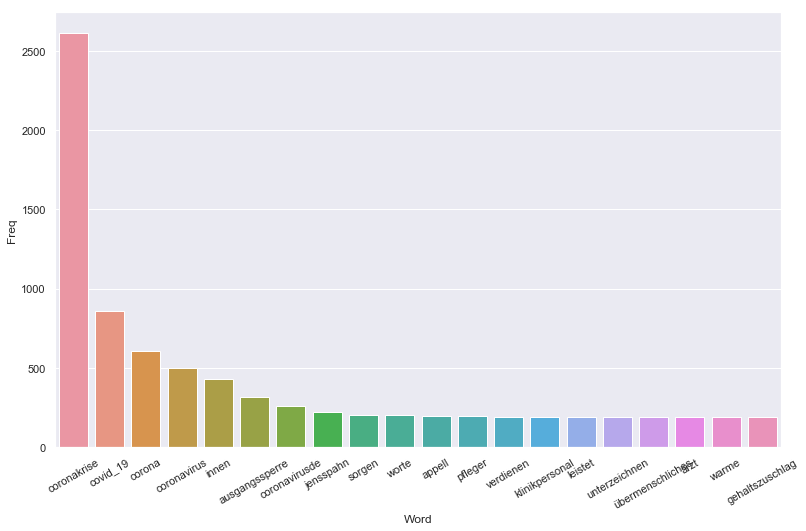

In [74]:
# Most frequently used words
txt = []
for val in tweets_pd.clean_text: 
      
    # typecaste each val to string 
    val = str(val)
    txt.append(val)
    
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(txt, n=20)
top_words_df = pd.DataFrame(top_words)
top_words_df.columns=["Word", "Freq"]

#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_words_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

[Text(0, 0, 'covid_19 corona'),
 Text(0, 0, 'ärzt innen'),
 Text(0, 0, 'klinikpersonal leistet'),
 Text(0, 0, 'innen pfleger'),
 Text(0, 0, 'pfleger innen'),
 Text(0, 0, 'leistet übermenschliches'),
 Text(0, 0, 'übermenschliches coronakrise'),
 Text(0, 0, 'coronakrise ärzt'),
 Text(0, 0, 'innen verdienen'),
 Text(0, 0, 'verdienen warme'),
 Text(0, 0, 'warme worte'),
 Text(0, 0, 'worte jensspahn'),
 Text(0, 0, 'jensspahn gehaltszuschlag'),
 Text(0, 0, 'gehaltszuschlag sorgen'),
 Text(0, 0, 'sorgen appell'),
 Text(0, 0, 'appell unterzeichnen'),
 Text(0, 0, 'unterzeichnen covid_19'),
 Text(0, 0, 'covid_19 coronakrise'),
 Text(0, 0, 'coronakrise covid_19'),
 Text(0, 0, 'coronakrise coronavirus')]

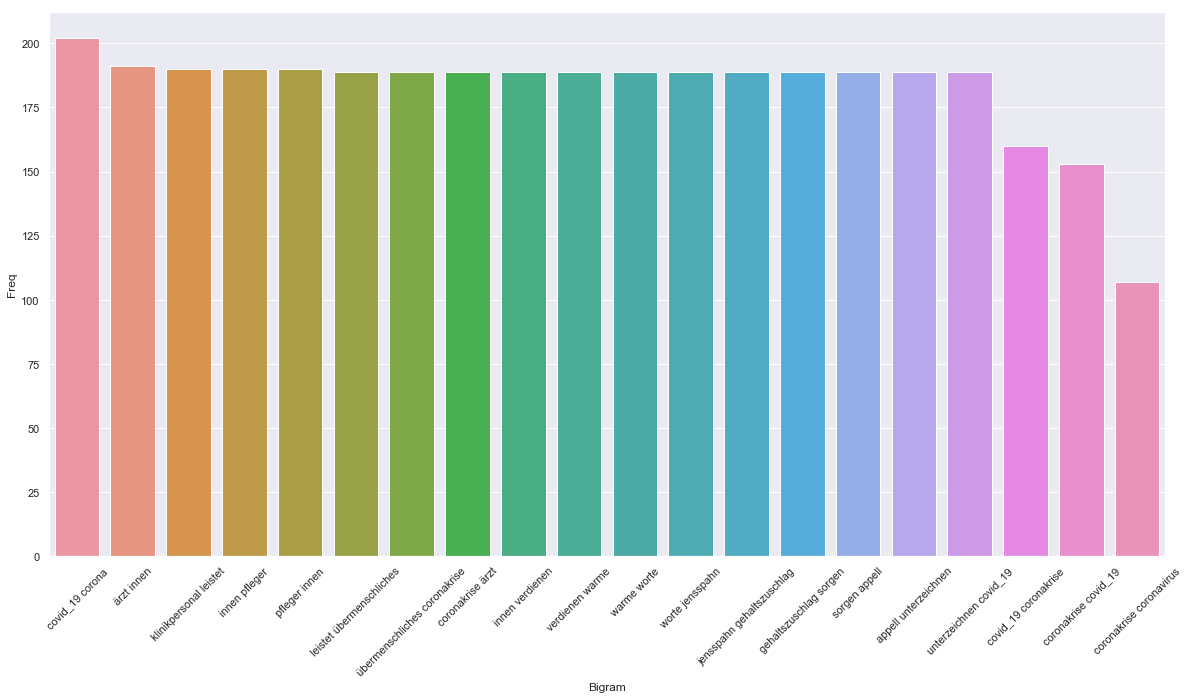

In [75]:
# Most freq Bigrams across all articles
top_bigrams_words = get_top_n2_words(txt, n=20)    
top_bigrams_df = pd.DataFrame(top_bigrams_words)
top_bigrams_df.columns=["Bigram", "Freq"]

#Barplot of most freq Bigrams
sns.set(rc={'figure.figsize':(20,10)})
h=sns.barplot(x="Bigram", y="Freq", data=top_bigrams_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

# Visualisation

## Timeline

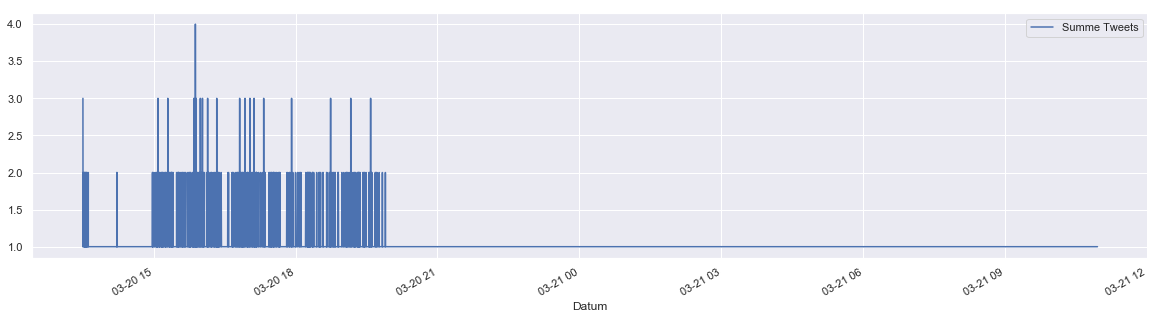

In [76]:
# Articles by day
artikel_pro_tag = tweets_pd.groupby(['created_at']).count()[['text']].reset_index()
artikel_pro_tag.columns = ('Datum', 'Summe Tweets')

fig, ax = plt.subplots(figsize=(20,5))
artikel_pro_tag.plot(x='Datum', y='Summe Tweets', ax=ax, kind = 'line')
plt.show()

## Word Cloud

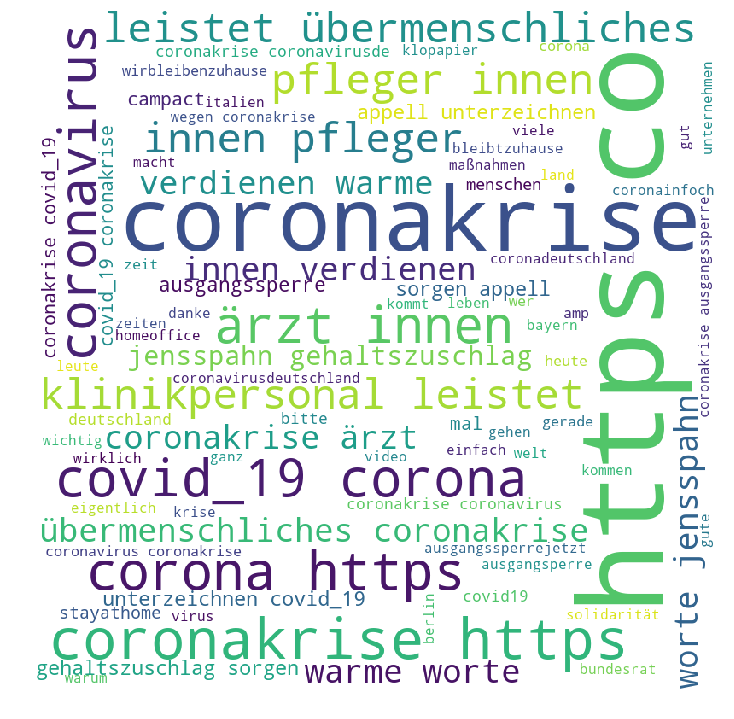

In [77]:
# Visualizing Word Frequency: Word Cloud
comment_words = ' '
  
# iterate through the df
for val in tweets_pd.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 14).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 16), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

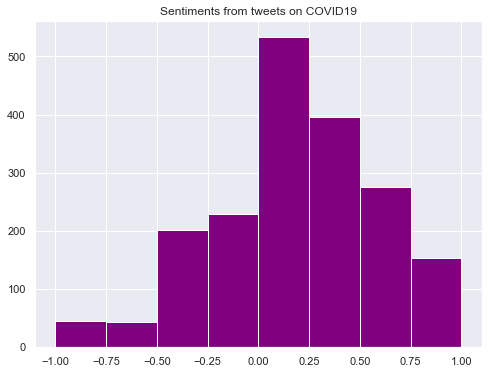

In [64]:
sentiment_values = []
for i in tweets_pd.text:
    sentiment = TextBlob(i).sentiment # Polarity greater 0 => positive, smaller 0 => negative; subjectivity > 0.5 fairly subjective
    sentiment_values.append(sentiment)

sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "subjectivity"])

sentiment_df

# Remove polarity values equal to zero
sentiment_df = sentiment_df.polarity[sentiment_df.polarity != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from tweets on COVID19")
plt.show()

# Not used analysis

In [65]:
"""Not Used"""
#Top 20 most frequent words for all the articles

cl_text_list = tweets_pd['clean_text'].tolist()
wf = word_freq(cl_text_list, 20)
wf.columns=("term", "frequency")
wf.head(10)

,term,frequency
0,coronakrise,2603
1,covid_19,855
2,corona,515
3,coronavirus,491
4,ausgangssperre,318
5,coronavirusde,261
6,jensspahn,219
7,sorgen,205
8,worte,202
9,appell,197
